#### SETUP

In [112]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

#### DATA LOADING

In [133]:
def load_data(url_directory, url_file, resizeX=256, resizeY=256):
    X = []
    y = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, (resizeX, resizeY))
            X.append(img_resized)
            y.append(int(line_split[2].strip()))

    return np.stack(X, axis=0), np.array(y)

In [114]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

X_train, y_train = load_data(url_directory, "train.txt")
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [120]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in temp_df.values}
n_classes_coarse = len(labels_coarse)
labels_coarse

{0: 'Apple',
 1: 'Avocado',
 2: 'Banana',
 3: 'Kiwi',
 4: 'Lemon',
 5: 'Lime',
 6: 'Mango',
 7: 'Melon',
 8: 'Nectarine',
 9: 'Orange',
 10: 'Papaya',
 11: 'Passion-Fruit',
 12: 'Peach',
 13: 'Pear',
 14: 'Pineapple',
 15: 'Plum',
 16: 'Pomegranate',
 17: 'Red-Grapefruit',
 18: 'Satsumas',
 19: 'Juice',
 20: 'Milk',
 21: 'Oatghurt',
 22: 'Oat-Milk',
 23: 'Sour-Cream',
 24: 'Sour-Milk',
 25: 'Soyghurt',
 26: 'Soy-Milk',
 27: 'Yoghurt',
 28: 'Asparagus',
 29: 'Aubergine',
 30: 'Cabbage',
 31: 'Carrots',
 32: 'Cucumber',
 33: 'Garlic',
 34: 'Ginger',
 35: 'Leek',
 36: 'Mushroom',
 37: 'Onion',
 38: 'Pepper',
 39: 'Potato',
 40: 'Red-Beet',
 41: 'Tomato',
 42: 'Zucchini'}

In [116]:
print(f"The shape of the training set is {X_train.shape}")
print(f"The shape of the validation set is {X_val.shape}")
print(f"The shape of the testing set is {X_test.shape}")

The shape of the training set is (2640, 224, 224, 3)
The shape of the validation set is (296, 224, 224, 3)
The shape of the testing set is (2485, 224, 224, 3)


#### DATA INSPECTION

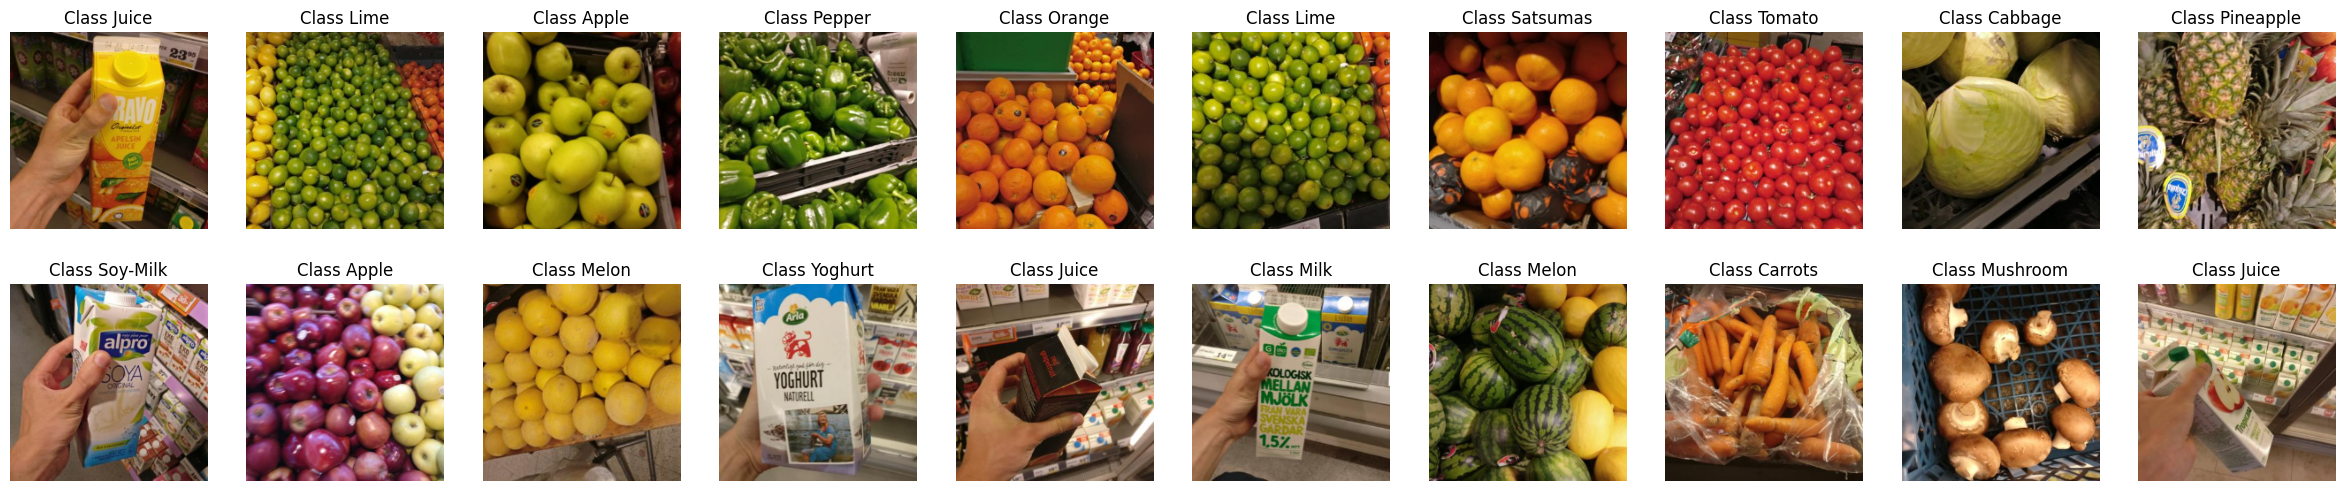

In [118]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train[rand_idx], cv2.COLOR_BGR2RGB))

#### DATA NORMALISATION

#### MODEL BUILDING

In [122]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = X_train.shape[1:]

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │     8,630,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,649,707 (33.00 MB)

 Trainable params: 8,649,707 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

#### MODEL TRAINING

In [124]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 64 #128
epochs = 8
val_split_percentage = 0.25

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

ERROR! Session/line number was not unique in database. History logging moved to new session 25
Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1561 - loss: 168.2023 - val_accuracy: 0.1385 - val_loss: 3.4938
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6572 - loss: 1.3879 - val_accuracy: 0.1453 - val_loss: 4.2330
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9246 - loss: 0.3488 - val_accuracy: 0.1453 - val_loss: 6.8184
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9830 - loss: 0.0931 - val_accuracy: 0.1453 - val_loss: 9.3257
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9943 - loss: 0.0516 - val_accuracy: 0.1554 - val_loss: 9.4844
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 0.1554 - val_loss: 12.6069
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.1520 - val_loss: 13.3808
Epoch 8/8
42/42 ━━━━━━━━

#### MODEL EVALUATION

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.1924 - loss: 10.6865
The test loss is 10.6865, the test accuracy is 0.1924.


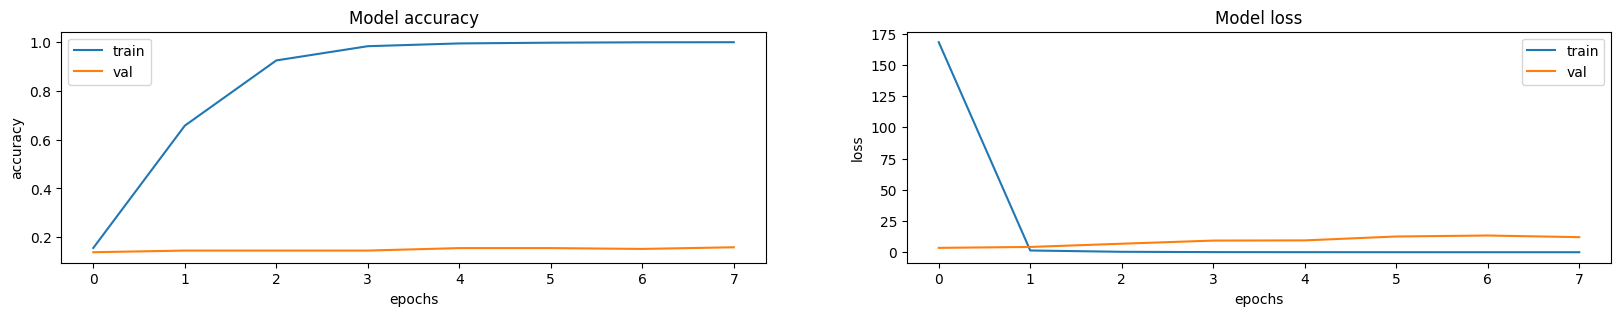

In [125]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

In [126]:
pred = model.predict(X_test)
print("Test Input Shape: {} Test output shape: {}".format(X_test.shape, pred.shape))

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step
Test Input Shape: (2485, 224, 224, 3) Test output shape: (2485, 43)


In [130]:
pred = np.argmax(pred, axis = -1)
print(pred)

[19 20  0 ... 19 38 42]


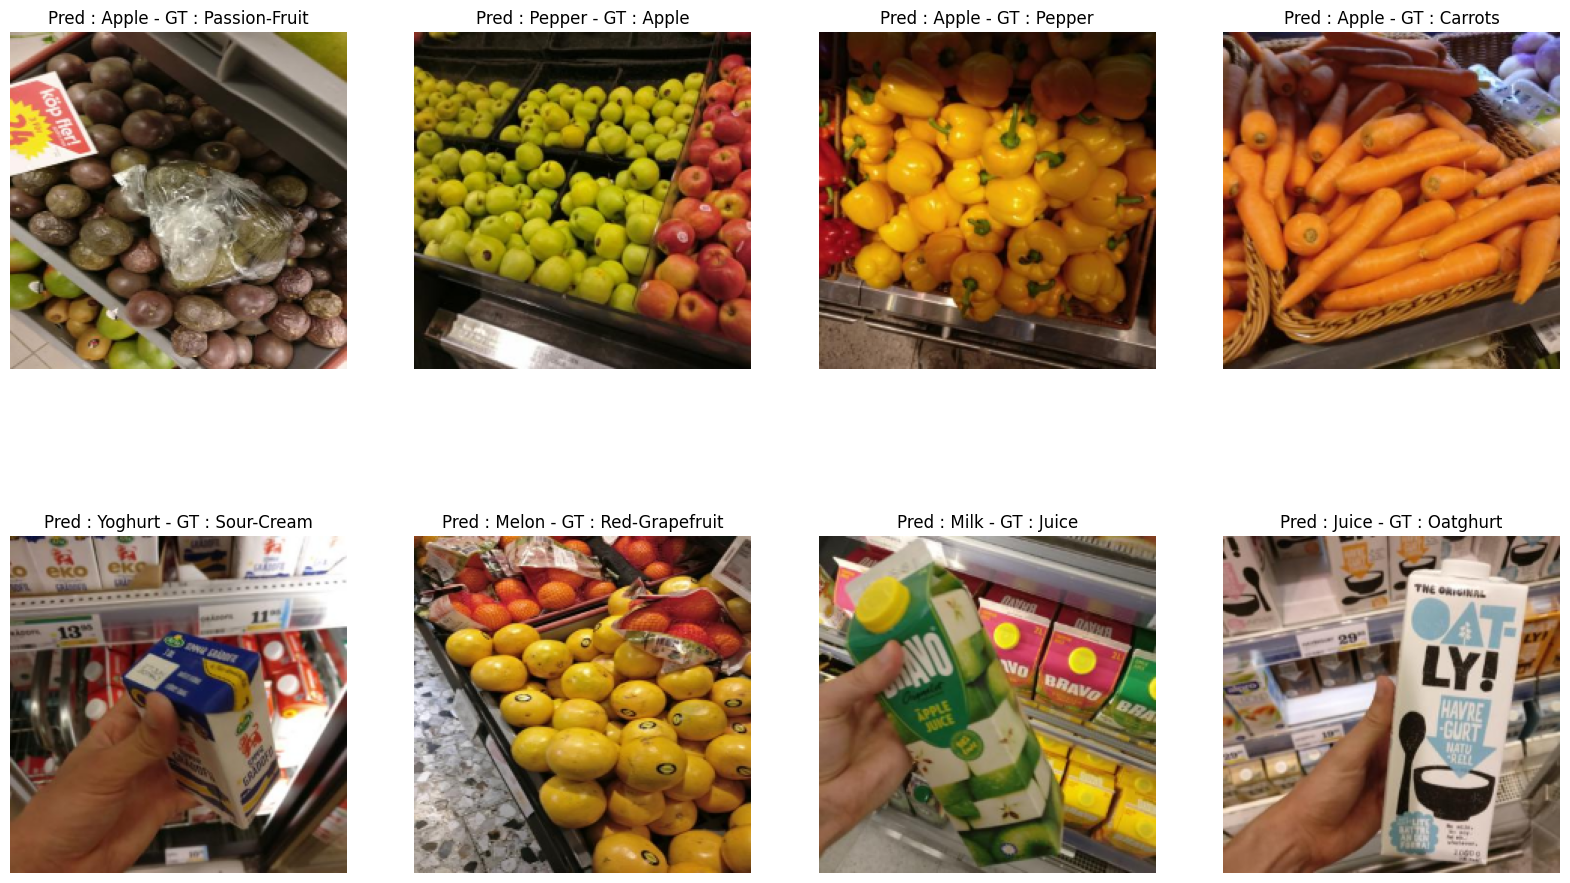

In [132]:
plt.figure(figsize=(20,12))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    rand_idx = np.random.randint(0, X_test.shape[0])
    plt.axis('off')
    plt.title(f"Pred : {labels_coarse[pred[rand_idx]]} - GT : {labels_coarse[y_test[rand_idx]]}")
    plt.imshow(cv2.cvtColor(X_test[rand_idx], cv2.COLOR_BGR2RGB))
plt.show()